## Ungraded Lab: Subword Tokenization with the IMDB Reviews Dataset

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Natural_Language_Processing_in_TensorFlow/Week2/Labs/C3_W2_Lab_3_imdb_subwords.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In this lab, you will look at a pre-tokenized dataset that is using subword text encoding. This is an alternative to word-based tokenization which you have been using in the previous labs. You will see how it works and its implications on preparing your data and training your model.

Let's begin!


## Download the IMDB reviews plain text and tokenized datasets

First, you will download the [IMDB Reviews](https://www.tensorflow.org/datasets/catalog/imdb_reviews) dataset from Tensorflow Datasets. You will get two configurations:

* `plain_text` - this is the default and the one you used in Lab 1 of this week
* `subwords8k` - a pre-tokenized dataset (i.e. instead of sentences of type string, it will already give you the tokenized sequences). You will see how this looks in later sections.

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from keras import Sequential, layers, Input
import matplotlib.pyplot as plt
import seaborn as sns

2024-06-13 01:55:52.805563: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Download the plain text default config
imdb_plaintext, info_plaintext = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

# Download the subword encoded pretokenized dataset
imdb_subwords, info_subwords = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

2024-06-13 01:55:54.963047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1766 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


## Compare the two datasets

As mentioned, the data types returned by the two datasets will be different. For the default, it will be strings as you also saw in Lab 1. Notice the description of the `text` key below and the sample sentences:

In [3]:
# Print description of features
info_plaintext.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'text': Text(shape=(), dtype=string),
})

In [4]:
# Take 2 training examples and print the text feature
for example in imdb_plaintext['train'].take(2):
    print(example[0].numpy())

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was

2024-06-13 01:55:55.255503: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-13 01:55:55.255906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


For `subwords8k`, the dataset is already tokenized so the data type will be integers. Notice that the `text` features also include an `encoder` field and has a `vocab_size` of around 8k, hence the name.

In [5]:
# Print description of features
info_subwords.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'text': Text(shape=(None,), dtype=int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})

If you print the results, you will not see string sentences but a sequence of tokens:

In [6]:
# Take 2 training examples and print its contents
for example in imdb_subwords['train'].take(2):
    print(example)

(<tf.Tensor: shape=(163,), dtype=int64, numpy=
array([  62,   18,   41,  604,  927,   65,    3,  644, 7968,   21,   35,
       5096,   36,   11,   43, 2948, 5240,  102,   50,  681, 7862, 1244,
          3, 3266,   29,  122,  640,    2,   26,   14,  279,  438,   35,
         79,  349,  384,   11, 1991,    3,  492,   79,  122,  188,  117,
         33, 4047, 4531,   14,   65, 7968,    8, 1819, 3947,    3,   62,
         27,    9,   41,  577, 5044, 2629, 2552, 7193, 7961, 3642,    3,
         19,  107, 3903,  225,   85,  198,   72,    1, 1512,  738, 2347,
        102, 6245,    8,   85,  308,   79, 6936, 7961,   23, 4981, 8044,
          3, 6429, 7961, 1141, 1335, 1848, 4848,   55, 3601, 4217, 8050,
          2,    5,   59, 3831, 1484, 8040, 7974,  174, 5773,   22, 5240,
        102,   18,  247,   26,    4, 3903, 1612, 3902,  291,   11,    4,
         27,   13,   18, 4092, 4008, 7961,    6,  119,  213, 2774,    3,
         12,  258, 2306,   13,   91,   29,  171,   52,  229,    2, 1245,
    

2024-06-13 01:55:55.309661: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-13 01:55:55.310122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


You can get the `encoder` object included in the download and use it to decode the sequences above. You'll see that you will arrive at the same sentences provided in the `plain_text` config:

In [7]:
# Get the encoder
tokenizer_subwords = info_subwords.features['text'].encoder

# Take 2 training examples and decode the text feature
for example in imdb_subwords['train'].take(2):
    print(tokenizer_subwords.decode(example[0]))

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was cons

2024-06-13 01:55:55.603584: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-13 01:55:55.711214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


*Note: The documentation for the encoder can be found [here](https://www.tensorflow.org/datasets/api_docs/python/tfds/deprecated/text/SubwordTextEncoder) but don't worry if it's marked as deprecated. As mentioned, the objective of this exercise is just to show the characteristics of subword encoding.*

## Subword Text Encoding

From previous labs, the number of tokens in the sequence is the same as the number of words in the text (i.e. word tokenization). The following cells shows a review of this process.

In [8]:
# Get the train set
train_data = imdb_plaintext['train']

# Initialize sentences list
training_sentences = []

# Loop over all training examples and save to the list
for s,_ in train_data:
    training_sentences.append(s.numpy().decode('utf8'))

2024-06-13 01:55:59.318174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
vocab_size = 10000
oov_tok = '<OOV>'

# Initialize the Tokenizer class
tokenizer_plaintext = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer_plaintext.fit_on_texts(training_sentences)

# Generate the training sequences
sequences = tokenizer_plaintext.texts_to_sequences(training_sentences)

The cell above uses a `vocab_size` of 10000 but you'll find that it's easy to find OOV tokens when decoding using the lookup dictionary it created. See the result below:

In [10]:
# Decode the first sequence using the Tokenizer class
tokenizer_plaintext.sequences_to_texts(sequences[0:1])

["this was an absolutely terrible movie don't be <OOV> in by christopher walken or michael <OOV> both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the <OOV> rebels were making their cases for <OOV> maria <OOV> <OOV> appeared phony and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actor's like christopher <OOV> good name i could barely sit through it"]

For binary classifiers, this might not have a big impact but you may have other applications that will benefit from avoiding OOV tokens when training the model (e.g. text generation). If you want the tokenizer above to not have OOVs, then the `vocab_size` will increase to more than 88k. This can slow down training and bloat the model size. The encoder also won't be robust when used on other datasets which may contain new words, thus resulting in OOVs again. 

In [11]:
# Total number of words in the word index dictionary
len(tokenizer_plaintext.word_index)

88583

*Subword text encoding* gets around this problem by using parts of the word to compose whole words. This makes it more flexible when it encounters uncommon words. See how these subwords look like for this particular encoder:

In [12]:
# Print the subwords
print(tokenizer_subwords.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

If you use it on the previous plain text sentence, you'll see that it won't have any OOVs even if it has a smaller vocab size (only 8k compared to 10k above):

In [13]:
# Encode the first plaintext sentence using the subword text encoder
tokenized_string = tokenizer_subwords.encode(training_sentences[0])
print(tokenized_string)

# Decode the sequence
original_string = tokenizer_subwords.decode(tokenized_string)

# Print the result
print (original_string)

[62, 18, 41, 604, 927, 65, 3, 644, 7968, 21, 35, 5096, 36, 11, 43, 2948, 5240, 102, 50, 681, 7862, 1244, 3, 3266, 29, 122, 640, 2, 26, 14, 279, 438, 35, 79, 349, 384, 11, 1991, 3, 492, 79, 122, 188, 117, 33, 4047, 4531, 14, 65, 7968, 8, 1819, 3947, 3, 62, 27, 9, 41, 577, 5044, 2629, 2552, 7193, 7961, 3642, 3, 19, 107, 3903, 225, 85, 198, 72, 1, 1512, 738, 2347, 102, 6245, 8, 85, 308, 79, 6936, 7961, 23, 4981, 8044, 3, 6429, 7961, 1141, 1335, 1848, 4848, 55, 3601, 4217, 8050, 2, 5, 59, 3831, 1484, 8040, 7974, 174, 5773, 22, 5240, 102, 18, 247, 26, 4, 3903, 1612, 3902, 291, 11, 4, 27, 13, 18, 4092, 4008, 7961, 6, 119, 213, 2774, 3, 12, 258, 2306, 13, 91, 29, 171, 52, 229, 2, 1245, 5790, 995, 7968, 8, 52, 2948, 5240, 8039, 7968, 8, 74, 1249, 3, 12, 117, 2438, 1369, 192, 39, 7975]
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not re

Subword encoding can even perform well on words that are not commonly found on movie reviews. See first the result when using the plain text tokenizer. As expected, it will show many OOVs:

In [14]:
# Define sample sentence
sample_string = 'TensorFlow, from basics to mastery'

# Encode using the plain text tokenizer
tokenized_string = tokenizer_plaintext.texts_to_sequences([sample_string])
print ('Tokenized string is {}'.format(tokenized_string))

# Decode and print the result
original_string = tokenizer_plaintext.sequences_to_texts(tokenized_string)
print ('The original string: {}'.format(original_string))

Tokenized string is [[1, 37, 1, 6, 1]]
The original string: ['<OOV> from <OOV> to <OOV>']


Then compare to the subword text encoder:

In [15]:
# Encode using the subword text encoder
tokenized_string = tokenizer_subwords.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

# Decode and print the results
original_string = tokenizer_subwords.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


As you may notice, the sentence is correctly decoded. The downside is the token sequence is much longer. Instead of only 5 when using word-encoding, you ended up with 11 tokens instead. The mapping for this sentence is shown below:

In [16]:
# Show token to subword mapping:
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer_subwords.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


## Training the model

You will now train your model using this pre-tokenized dataset. Since these are already saved as sequences, you can jump straight to making uniform sized arrays for the train and test sets. These are also saved as `tf.data.Dataset` type so you can use the [`padded_batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch) method to create batches and pad the arrays into a uniform size for training.

In [17]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# Get the train and test splits
train_data, test_data = imdb_subwords['train'], imdb_subwords['test'], 

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

Next, you will build the model. You can just use the architecture from the previous lab. 

In [18]:
# Define dimensionality of the embedding
embedding_dim = 64

# Build the model
model = Sequential([Input(shape=(None,)),
                    layers.Embedding(tokenizer_subwords.vocab_size, embedding_dim),
                    layers.GlobalAveragePooling1D(),
                    layers.Dense(6, activation='relu'),
                    layers.Dense(1, activation='sigmoid')])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 64)       │       523,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 524,237 (2.00 MB)

 Trainable params: 524,237 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

Similarly, you can use the same parameters for training. In Colab, it will take around 20 seconds per epoch (without an accelerator) and you will reach around 94% training accuracy and 88% validation accuracy.

In [19]:
num_epochs = 10

# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Start training
history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10


I0000 00:00:1718265364.674850  239208 service.cc:145] XLA service 0x7fc7e0004260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718265364.674884  239208 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-06-13 01:56:04.693882: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-13 01:56:04.798810: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  1/391 ━━━━━━━━━━━━━━━━━━━━ 8:18 1s/step - accuracy: 0.5625 - loss: 0.6909

I0000 00:00:1718265365.200627  239208 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 ━━━━━━━━━━━━━━━━━━━━ 121s 307ms/step - accuracy: 0.5058 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.5077 - loss: 0.6917 - val_accuracy: 0.5090 - val_loss: 0.6830
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5464 - loss: 0.6839 - val_accuracy: 0.6565 - val_loss: 0.6212
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.6355 - loss: 0.6414 - val_accuracy: 0.6199 - val_loss: 0.6081
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.7324 - loss: 0.5333 - val_accuracy: 0.8140 - val_loss: 0.4721
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7579 - loss: 0.4988 - val_accuracy: 0.7442 - val_loss: 0.4829
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.7979 - loss: 0.4342 - val_accuracy: 0.8322 - val_loss: 0.4132
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7981 - loss: 0.4349 - val_accuracy

## Visualize the results

You can use the cell below to plot the training results. See if you can improve it by tweaking the parameters such as the size of the embedding and number of epochs.

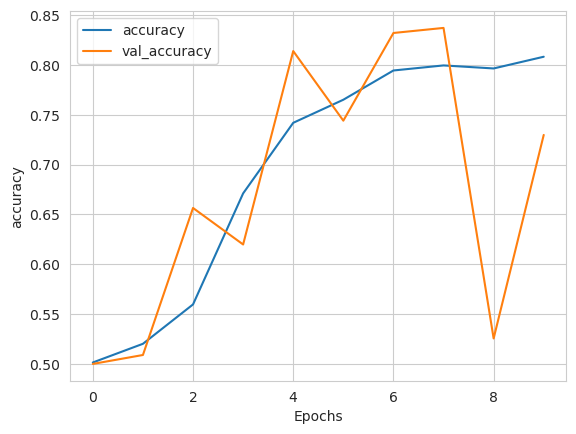

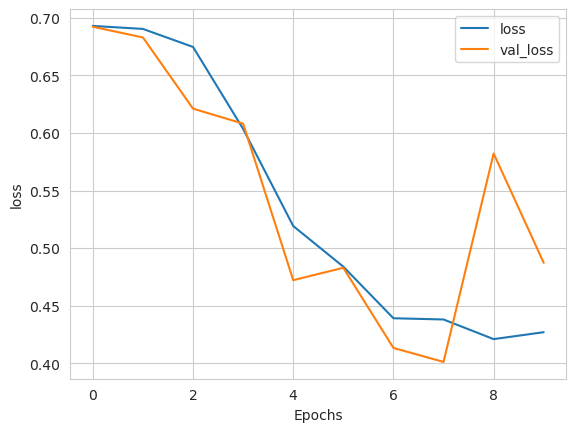

In [20]:
sns.set_style("whitegrid")

# Plot utility
def plot_graphs(history, string):
    plt.figure()
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Wrap Up

In this lab, you saw how subword text encoding can be a robust technique to avoid out-of-vocabulary tokens. It can decode uncommon words it hasn't seen before even with a relatively small vocab size. Consequently, it results in longer token sequences when compared to full word tokenization. Next week, you will look at other architectures that you can use when building your classifier. These will be recurrent neural networks and convolutional neural networks.